#### Aziz Guergachi - Javed Hakim | GHICM Model Simulations

This article has one single purpose: introduce a new and simple, yet highly insightful approach to capture, fully and quantitatively, the dynamics of the circular flow of income in economies. The proposed approach relies mostly on basic linear algebraic concepts and has deep implications for the disciplines of economics, physics and econophysics.

**https://doi.org/10.48550/arXiv.2307.02713**

In [17]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix, diags
import matplotlib.pyplot as plt
import gc
from typing import Tuple, List, Optional
import warnings
import psutil
from tqdm.notebook import tqdm
import time

warnings.filterwarnings('ignore')

# Jupyter setup
%matplotlib inline

# Better display options
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 3)

# Simple matplotlib style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True

print("✅ All imports successful!")
print(f"Available RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")

✅ All imports successful!
Available RAM: 8.0 GB


In [18]:
def print_memory_usage(label=""):
    """Print current memory usage"""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / (1024 * 1024)
    available_gb = psutil.virtual_memory().available / (1024**3)
    print(f"{label} Memory usage: {memory_mb:.1f} MB | Available: {available_gb:.1f} GB")
    return memory_mb

def cleanup_memory():
    """Force garbage collection"""
    gc.collect()
    print("🧹 Memory cleaned up")

def format_number(num):
    """Format large numbers nicely"""
    if num >= 1e9:
        return f"{num/1e9:.1f}B"
    elif num >= 1e6:
        return f"{num/1e6:.1f}M"
    elif num >= 1e3:
        return f"{num/1e3:.1f}K"
    else:
        return str(int(num))

print("✅ Utility functions loaded!")

✅ Utility functions loaded!


In [19]:
class ScalableICM:
    def __init__(self, n_agents: int, interact_percent: float = 0.5, 
                 chunk_size: int = 10000, use_gpu: bool = False):
        """
        Initialize Scalable Income Circulation Model
        """
        self.n = n_agents
        self.interact_percent = interact_percent
        self.chunk_size = min(chunk_size, n_agents)
        self.use_gpu = use_gpu
        
        if use_gpu:
            try:
                import cupy as cp
                self.cp = cp
                print("🚀 GPU acceleration enabled")
            except ImportError:
                print("⚠️ CuPy not available, falling back to CPU")
                self.use_gpu = False
        
        self.wealth_history = []
        self.current_step = 0
    
    def generate_initial_wealth(self, seed: int = 42, 
                              model: str = "boltzgibbs",
                              lower_bound: float = 1000,
                              upper_bound: float = 100000000) -> np.ndarray:
        """Generate initial wealth distribution efficiently"""
        np.random.seed(seed)
        
        if model == "boltzgibbs":
            T = 100000
            rate = 1 / T
            wealth = np.random.exponential(scale=1/rate, size=self.n)
            
            # Add Pareto tail for top 10%
            num_high = int(0.1 * self.n)
            pareto_wealth = np.random.pareto(1.5, size=num_high)
            wealth[:num_high] += pareto_wealth
            
        elif model == "random":
            wealth = np.random.rand(self.n)
        else:
            wealth = np.ones(self.n)
        
        # Scale to desired range
        wealth = lower_bound + (wealth - wealth.min()) / (wealth.max() - wealth.min()) * (upper_bound - lower_bound)
        
        return np.sort(wealth)[::-1]  # Sort in descending order
    
    def generate_sparse_F0(self, seed: int = 42) -> sparse.csr_matrix:
        """Generate initial sparse Income Circulation Matrix"""
        np.random.seed(seed)
        
        # Generate wealth fractions for diagonal (savings)
        wealth_fractions = np.random.rand(self.n)
        wealth_fractions = np.sort(wealth_fractions)[::-1]  # Descending order
        
        n_interactions = int(self.n * self.interact_percent / 100)
        
        # Pre-allocate arrays
        row_indices = []
        col_indices = []
        data = []
        
        print(f"Generating F0 with {format_number(self.n)} agents, {self.interact_percent}% interaction rate...")
        
        # Process in chunks to manage memory
        for chunk_start in tqdm(range(0, self.n, self.chunk_size), desc="Processing chunks"):
            chunk_end = min(chunk_start + self.chunk_size, self.n)
            
            # Add diagonal elements for this chunk
            for i in range(chunk_start, chunk_end):
                row_indices.append(i)
                col_indices.append(i)
                data.append(wealth_fractions[i])
            
            # Add interaction elements for this chunk
            for j in range(chunk_start, chunk_end):
                if n_interactions > 0 and n_interactions < self.n - 1:
                    # Select interacting agents (excluding self)
                    available_agents = np.arange(self.n)
                    available_agents = available_agents[available_agents != j]
                    
                    selected_agents = np.random.choice(
                        available_agents, 
                        min(n_interactions, len(available_agents)), 
                        replace=False
                    )
                    
                    # Generate interaction weights
                    interaction_weights = np.random.exponential(0.1, len(selected_agents))
                    interaction_weights /= interaction_weights.sum()
                    interaction_weights *= (1 - wealth_fractions[j])
                    
                    for i, weight in zip(selected_agents, interaction_weights):
                        row_indices.append(i)
                        col_indices.append(j)
                        data.append(weight)
            
            # Garbage collection for large matrices
            if self.n > 100000 and chunk_start % (10 * self.chunk_size) == 0:
                gc.collect()
        
        # Convert to numpy arrays
        row_indices = np.array(row_indices, dtype=np.int32)
        col_indices = np.array(col_indices, dtype=np.int32)
        data = np.array(data)
        
        # Create sparse matrix
        F = sparse.csr_matrix((data, (row_indices, col_indices)), 
                             shape=(self.n, self.n))
        
        # Normalize columns to ensure stochasticity
        F = self._normalize_columns_sparse(F)
        
        return F
    
    def _normalize_columns_sparse(self, F: sparse.csr_matrix) -> sparse.csr_matrix:
        """Normalize columns of sparse matrix to sum to 1"""
        # Convert to CSC for efficient column operations
        F_csc = F.tocsc()
        
        # Add small epsilon to prevent zero columns
        epsilon = 1e-8
        col_sums = np.array(F_csc.sum(axis=0)).flatten()
        col_sums[col_sums == 0] = epsilon
        
        # Normalize each column
        col_sums_diag = sparse.diags(1.0 / col_sums, format='csr')
        F_normalized = F_csc @ col_sums_diag
        
        return F_normalized.tocsr()
    
    def evolve_sparse_F(self, F_prev: sparse.csr_matrix, 
                       a_percent: float = 2, b_percent: float = 2, 
                       c_percent: float = 2, step_seed: int = 42) -> sparse.csr_matrix:
        """Evolve the sparse ICM matrix efficiently"""
        np.random.seed(step_seed)
        
        F_new = F_prev.copy()
        
        # Select columns to modify
        n_cols_modify = max(1, int(a_percent * self.n / 100))
        cols_to_modify = np.random.choice(self.n, n_cols_modify, replace=False)
        
        # Process modifications in chunks
        for chunk_start in range(0, len(cols_to_modify), min(self.chunk_size, 1000)):
            chunk_end = min(chunk_start + min(self.chunk_size, 1000), len(cols_to_modify))
            chunk_cols = cols_to_modify[chunk_start:chunk_end]
            
            for j in chunk_cols:
                # Get column data
                col_data = F_new.getcol(j).toarray().flatten()
                non_zero_indices = np.nonzero(col_data)[0]
                
                if len(non_zero_indices) > 0:
                    # Select elements to modify
                    n_elements_modify = max(1, int(b_percent * len(non_zero_indices) / 100))
                    elements_to_modify = np.random.choice(
                        non_zero_indices, 
                        min(n_elements_modify, len(non_zero_indices)), 
                        replace=False
                    )
                    
                    # Apply modifications
                    for i in elements_to_modify:
                        change = np.random.uniform(-c_percent / 100, c_percent / 100)
                        new_value = max(0, min(1, col_data[i] + change))
                        F_new[i, j] = new_value
            
            # Normalize modified columns
            for j in chunk_cols:
                col_sum = F_new[:, j].sum()
                if col_sum > 0:
                    F_new[:, j] /= col_sum
        
        return F_new
    
    def sparse_matrix_vector_mult(self, F: sparse.csr_matrix, 
                                 x: np.ndarray) -> np.ndarray:
        """Efficient sparse matrix-vector multiplication"""
        if self.use_gpu:
            F_gpu = self.cp.sparse.csr_matrix(F)
            x_gpu = self.cp.array(x)
            result_gpu = F_gpu @ x_gpu
            return self.cp.asnumpy(result_gpu)
        else:
            return F @ x
    
    def simulate_wealth_evolution(self, X0: np.ndarray, 
                                 F_matrices: List[sparse.csr_matrix],
                                 injection_step: int = 20,
                                 injection_percent: float = 15,
                                 top_percent: float = 10,
                                 bottom_percent: float = 40) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Simulate wealth evolution with optional injection"""
        
        X_no_injection = [X0.copy()]
        X_with_injection = [X0.copy()]
        
        print(f"Simulating {len(F_matrices)} steps for {format_number(self.n)} agents...")
        
        # Evolution without injection
        current_X = X0.copy()
        for t, F in enumerate(tqdm(F_matrices, desc="No injection")):
            current_X = self.sparse_matrix_vector_mult(F, current_X)
            X_no_injection.append(current_X.copy())
        
        # Evolution with injection
        current_X_inj = X0.copy()
        for t, F in enumerate(tqdm(F_matrices, desc="With injection")):
            if t == injection_step:
                print(f"💰 Applying {injection_percent}% wealth injection at step {t}")
                current_X_inj = self._apply_injection(
                    current_X_inj, top_percent, bottom_percent, injection_percent
                )
            
            current_X_inj = self.sparse_matrix_vector_mult(F, current_X_inj)
            X_with_injection.append(current_X_inj.copy())
        
        return X_no_injection, X_with_injection
    
    def _apply_injection(self, X: np.ndarray, top_percent: float, 
                        bottom_percent: float, injection_percent: float) -> np.ndarray:
        """Apply wealth injection from top to bottom agents"""
        X_new = X.copy()
        
        top_k = int(np.ceil(top_percent / 100 * self.n))
        bottom_k = int(np.ceil(bottom_percent / 100 * self.n))
        
        # Calculate total injection amount
        total_injection = np.sum(X_new[:top_k]) * (injection_percent / 100)
        
        # Remove from top agents
        X_new[:top_k] *= (1 - injection_percent / 100)
        
        # Distribute to bottom agents
        injection_per_agent = total_injection / bottom_k
        X_new[-bottom_k:] += injection_per_agent
        
        return X_new
    
    def analyze_wealth_distribution(self, X_matrices: List[np.ndarray],
                                   top_percent: float = 10,
                                   bottom_percent: float = 40) -> pd.DataFrame:
        """Analyze wealth distribution over time"""
        results = []
        
        for t, X in enumerate(X_matrices):
            top_k = int(np.ceil(top_percent / 100 * self.n))
            bottom_k = int(np.ceil(bottom_percent / 100 * self.n))
            
            top_wealth = np.sum(X[:top_k])
            bottom_wealth = np.sum(X[-bottom_k:])
            total_wealth = np.sum(X)
            
            results.append({
                'step': t,
                'top_wealth': top_wealth,
                'bottom_wealth': bottom_wealth,
                'total_wealth': total_wealth,
                'top_ratio': top_wealth / total_wealth,
                'bottom_ratio': bottom_wealth / total_wealth,
                'inequality_ratio': top_wealth / bottom_wealth if bottom_wealth > 0 else np.inf
            })
        
        return pd.DataFrame(results)
    
    def plot_wealth_evolution(self, df_no_inj: pd.DataFrame, 
                             df_with_inj: pd.DataFrame,
                             injection_step: int = 20,
                             top_percent: float = 10,
                             bottom_percent: float = 40):
        """Plot wealth evolution comparison"""
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Top wealth comparison
        ax1.plot(df_no_inj['step'], df_no_inj['top_wealth'], 
                label=f'No Injection', color='teal', linewidth=2)
        ax1.plot(df_with_inj['step'], df_with_inj['top_wealth'], 
                label=f'With Injection', color='peru', linewidth=2)
        ax1.axvline(injection_step, color='red', linestyle='--', alpha=0.7, label='Injection')
        ax1.set_title(f'Top {top_percent}% Wealth Evolution ({format_number(self.n)} agents)', fontweight='bold')
        ax1.set_ylabel('Wealth')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Bottom wealth comparison
        ax2.plot(df_no_inj['step'], df_no_inj['bottom_wealth'], 
                label=f'No Injection', color='teal', linewidth=2)
        ax2.plot(df_with_inj['step'], df_with_inj['bottom_wealth'], 
                label=f'With Injection', color='peru', linewidth=2)
        ax2.axvline(injection_step, color='red', linestyle='--', alpha=0.7, label='Injection')
        ax2.set_title(f'Bottom {bottom_percent}% Wealth Evolution', fontweight='bold')
        ax2.set_ylabel('Wealth')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Inequality ratio
        ax3.plot(df_no_inj['step'], df_no_inj['inequality_ratio'], 
                label=f'No Injection', color='teal', linewidth=2)
        ax3.plot(df_with_inj['step'], df_with_inj['inequality_ratio'], 
                label=f'With Injection', color='peru', linewidth=2)
        ax3.axvline(injection_step, color='red', linestyle='--', alpha=0.7, label='Injection')
        ax3.set_title('Wealth Inequality Ratio (Top/Bottom)', fontweight='bold')
        ax3.set_ylabel('Ratio')
        ax3.set_xlabel('Time Step')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Wealth ratios over time
        ax4.plot(df_no_inj['step'], df_no_inj['top_ratio'], 
                label=f'Top {top_percent}% (No Inj)', color='darkblue', linewidth=2)
        ax4.plot(df_with_inj['step'], df_with_inj['top_ratio'], 
                label=f'Top {top_percent}% (With Inj)', color='darkred', linewidth=2)
        ax4.plot(df_no_inj['step'], df_no_inj['bottom_ratio'], 
                label=f'Bottom {bottom_percent}% (No Inj)', color='lightblue', linewidth=2)
        ax4.plot(df_with_inj['step'], df_with_inj['bottom_ratio'], 
                label=f'Bottom {bottom_percent}% (With Inj)', color='lightcoral', linewidth=2)
        ax4.axvline(injection_step, color='red', linestyle='--', alpha=0.7, label='Injection')
        ax4.set_title('Wealth Share Ratios', fontweight='bold')
        ax4.set_ylabel('Share of Total Wealth')
        ax4.set_xlabel('Time Step')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle(f'ICM Results: {format_number(self.n)} Agents, {self.interact_percent}% Interaction Rate', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def memory_usage_estimate(self) -> dict:
        """Estimate memory usage for the simulation"""
        
        # Sparse matrix memory (assuming interaction rate density)
        density = self.interact_percent / 100 + 1/self.n  # interactions + diagonal
        nnz = int(density * self.n * self.n)
        sparse_matrix_mb = (nnz * (8 + 4 + 4)) / (1024**2)  # data + indices
        
        # Wealth vectors memory
        wealth_vector_mb = self.n * 8 / (1024**2)  # float64
        
        # Total estimation
        total_mb = sparse_matrix_mb + wealth_vector_mb * 2  # two vectors
        
        return {
            'sparse_matrix_mb': sparse_matrix_mb,
            'wealth_vectors_mb': wealth_vector_mb * 2,
            'total_estimated_mb': total_mb,
            'agents': format_number(self.n),
            'density': f"{density:.6%}",
            'nnz': format_number(nnz)
        }

print("✅ ScalableICM class loaded successfully!")

✅ ScalableICM class loaded successfully!


In [20]:
# Optimized settings for 1,000,000 agents
print("🚀 LARGE SCALE: 1,000,000 agents")
print("=" * 50)

# OPTIMIZED PARAMETERS
N_AGENTS = 1000
INTERACT_PERCENT = 0.1      # Very low for efficiency - still realistic
N_STEPS = 25               # Reasonable number of time steps
INJECTION_STEP = 12        # Middle of simulation
INJECTION_PERCENT = 15     # Standard redistribution
CHUNK_SIZE = 15000         # Optimized for 1M agents
TOP_PERCENT = 10
BOTTOM_PERCENT = 40

# Initialize optimized model
model = ScalableICM(
    n_agents=N_AGENTS, 
    interact_percent=INTERACT_PERCENT,
    chunk_size=CHUNK_SIZE,
    use_gpu=False  # Set to True if you have NVIDIA GPU with CuPy
)

print(f"📊 Configuration:")
print(f"   • Agents: {format_number(N_AGENTS)}")
print(f"   • Interaction rate: {INTERACT_PERCENT}%")
print(f"   • Time steps: {N_STEPS}")
print(f"   • Chunk size: {CHUNK_SIZE:,}")

🚀 LARGE SCALE: 1,000,000 agents
📊 Configuration:
   • Agents: 1.0K
   • Interaction rate: 0.1%
   • Time steps: 25
   • Chunk size: 15,000


In [21]:
# CRITICAL: Check memory requirements first
memory_info = model.memory_usage_estimate()
available_gb = psutil.virtual_memory().available / (1024**3)
required_gb = memory_info['total_estimated_mb'] / 1024

print(f"💾 MEMORY ANALYSIS:")
print(f"   • Required: {required_gb:.2f} GB")
print(f"   • Available: {available_gb:.2f} GB")
print(f"   • Matrix density: {memory_info['density']}")
print(f"   • Non-zero elements: {memory_info['nnz']}")

# Safety check
if required_gb > available_gb * 0.75:
    print("❌ WARNING: High memory usage!")
    print("💡 Reduce INTERACT_PERCENT to 0.05% or N_AGENTS to 500K")
    
    # Suggest alternative
    alt_interact = 0.05
    model_alt = ScalableICM(n_agents=N_AGENTS, interact_percent=alt_interact)
    alt_memory = model_alt.memory_usage_estimate()
    print(f"🔄 Alternative: {alt_interact}% interaction = {alt_memory['total_estimated_mb']/1024:.2f} GB")
else:
    print("✅ Memory requirements are safe!")

# System optimization
import os
os.environ['NUMBA_NUM_THREADS'] = str(min(8, os.cpu_count()))  # Limit to 8 cores max
print(f"🖥️ Using {os.environ['NUMBA_NUM_THREADS']} CPU cores")

print_memory_usage("Before simulation:")

💾 MEMORY ANALYSIS:
   • Required: 0.00 GB
   • Available: 0.33 GB
   • Matrix density: 0.200000%
   • Non-zero elements: 2.0K
✅ Memory requirements are safe!
🖥️ Using 8 CPU cores
Before simulation: Memory usage: 519.7 MB | Available: 0.3 GB


519.69140625

In [22]:
print("💰 Generating initial wealth distribution...")
start_time = time.time()

# Generate with progress tracking
X0 = model.generate_initial_wealth(
    seed=42, 
    model="boltzgibbs",
    lower_bound=1000,
    upper_bound=50000000  # Slightly reduced upper bound for stability
)

wealth_time = time.time() - start_time
print(f"✅ Wealth generation completed in {wealth_time:.2f}s")
print(f"📊 Wealth range: ${X0.min():,.0f} - ${X0.max():,.0f}")
print(f"📊 Top 1% threshold: ${np.percentile(X0, 99):,.0f}")
print(f"📊 Bottom 10% threshold: ${np.percentile(X0, 10):,.0f}")

print_memory_usage("After wealth generation:")

💰 Generating initial wealth distribution...
✅ Wealth generation completed in 0.00s
📊 Wealth range: $1,000 - $50,000,000
📊 Top 1% threshold: $26,333,416
📊 Bottom 10% threshold: $569,782
After wealth generation: Memory usage: 521.3 MB | Available: 0.3 GB


521.30078125

In [23]:
print("🔗 Generating initial F matrix (this may take 2-5 minutes)...")
start_time = time.time()

# Generate with optimized settings
F0 = model.generate_sparse_F0(seed=42)

matrix_time = time.time() - start_time
print(f"✅ F0 generation completed in {matrix_time:.1f}s")
print(f"📊 Matrix info:")
print(f"   • Shape: {F0.shape}")
print(f"   • Non-zeros: {F0.nnz:,}")
print(f"   • Density: {F0.nnz/(F0.shape[0]*F0.shape[1]):.8f}")
print(f"   • Memory usage: ~{(F0.nnz * 16) / (1024**2):.0f} MB")

# Verify column stochasticity
col_sums = np.array(F0.sum(axis=0)).flatten()
print(f"✅ Matrix validation: columns sum to {col_sums.mean():.6f} ± {col_sums.std():.6f}")

print_memory_usage("After F0 generation:")

🔗 Generating initial F matrix (this may take 2-5 minutes)...
Generating F0 with 1.0K agents, 0.1% interaction rate...


Processing chunks:   0%|          | 0/1 [00:00<?, ?it/s]

✅ F0 generation completed in 0.1s
📊 Matrix info:
   • Shape: (1000, 1000)
   • Non-zeros: 2,000
   • Density: 0.00200000
   • Memory usage: ~0 MB
✅ Matrix validation: columns sum to 1.000000 ± 0.000000
After F0 generation: Memory usage: 638.2 MB | Available: 0.3 GB


638.203125

In [24]:
print("⚡ Generating evolution matrices...")
print("📅 This will take 3-8 minutes for 1M agents")

F_matrices = [F0]
start_time = time.time()

# Optimized evolution parameters
A_PERCENT = 1.5  # Reduced from 2% for speed
B_PERCENT = 1.5  # Reduced from 2% for speed  
C_PERCENT = 1.0  # Reduced volatility for stability

for t in tqdm(range(1, N_STEPS), desc="Evolving matrices"):
    # Memory monitoring every 5 steps
    if t % 5 == 0:
        print_memory_usage(f"  Step {t}:")
        gc.collect()  # Force cleanup every 5 steps
    
    F_new = model.evolve_sparse_F(
        F_matrices[-1], 
        a_percent=A_PERCENT,
        b_percent=B_PERCENT, 
        c_percent=C_PERCENT,
        step_seed=42+t
    )
    F_matrices.append(F_new)

evolution_time = time.time() - start_time
print(f"✅ Evolution completed in {evolution_time:.1f}s")
print(f"📊 Generated {len(F_matrices)} matrices")

print_memory_usage("After matrix evolution:")
cleanup_memory()

⚡ Generating evolution matrices...
📅 This will take 3-8 minutes for 1M agents


Evolving matrices:   0%|          | 0/24 [00:00<?, ?it/s]

  Step 5: Memory usage: 638.3 MB | Available: 0.5 GB
  Step 10: Memory usage: 638.3 MB | Available: 0.5 GB
  Step 15: Memory usage: 638.4 MB | Available: 0.5 GB
  Step 20: Memory usage: 638.4 MB | Available: 0.5 GB
✅ Evolution completed in 0.6s
📊 Generated 25 matrices
After matrix evolution: Memory usage: 638.4 MB | Available: 0.5 GB
🧹 Memory cleaned up


In [25]:
print("🎯 Running wealth simulation...")
print("⏱️ Estimated time: 2-5 minutes")

start_time = time.time()

# Run with progress tracking
X_no_inj, X_with_inj = model.simulate_wealth_evolution(
    X0, F_matrices,
    injection_step=INJECTION_STEP,
    injection_percent=INJECTION_PERCENT,
    top_percent=TOP_PERCENT,
    bottom_percent=BOTTOM_PERCENT
)

simulation_time = time.time() - start_time
total_time = wealth_time + matrix_time + evolution_time + simulation_time

print(f"✅ SIMULATION COMPLETED!")
print(f"⏱️ Performance summary:")
print(f"   • Wealth generation: {wealth_time:.1f}s")
print(f"   • F0 matrix: {matrix_time:.1f}s") 
print(f"   • Evolution: {evolution_time:.1f}s")
print(f"   • Simulation: {simulation_time:.1f}s")
print(f"   • TOTAL: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"   • Performance: {N_AGENTS*N_STEPS/total_time:,.0f} agent-steps/second")

print_memory_usage("Peak memory:")

🎯 Running wealth simulation...
⏱️ Estimated time: 2-5 minutes
Simulating 25 steps for 1.0K agents...


No injection:   0%|          | 0/25 [00:00<?, ?it/s]

With injection:   0%|          | 0/25 [00:00<?, ?it/s]

💰 Applying 15% wealth injection at step 12
✅ SIMULATION COMPLETED!
⏱️ Performance summary:
   • Wealth generation: 0.0s
   • F0 matrix: 0.1s
   • Evolution: 0.6s
   • Simulation: 0.0s
   • TOTAL: 0.7s (0.0 minutes)
   • Performance: 35,007 agent-steps/second
Peak memory: Memory usage: 638.4 MB | Available: 0.5 GB


638.42578125

In [26]:
print("📊 Analyzing results for 1M agents...")

# Quick analysis
df_no_inj = model.analyze_wealth_distribution(X_no_inj, TOP_PERCENT, BOTTOM_PERCENT)
df_with_inj = model.analyze_wealth_distribution(X_with_inj, TOP_PERCENT, BOTTOM_PERCENT)

# Summary statistics
print(f"\n📋 RESULTS SUMMARY ({format_number(N_AGENTS)} agents):")
print(f"{'Scenario':<20} {'Top 10%':<12} {'Bottom 40%':<12} {'Inequality':<12}")
print("-" * 60)

final_no_inj = df_no_inj.iloc[-1]
final_with_inj = df_with_inj.iloc[-1]

print(f"{'No Injection':<20} {final_no_inj['top_ratio']:>10.1%} {final_no_inj['bottom_ratio']:>11.1%} {final_no_inj['inequality_ratio']:>11.2f}")
print(f"{'With Injection':<20} {final_with_inj['top_ratio']:>10.1%} {final_with_inj['bottom_ratio']:>11.1%} {final_with_inj['inequality_ratio']:>11.2f}")

# Impact analysis
wealth_reduction = (final_no_inj['top_ratio'] - final_with_inj['top_ratio']) / final_no_inj['top_ratio']
wealth_increase = (final_with_inj['bottom_ratio'] - final_no_inj['bottom_ratio']) / final_no_inj['bottom_ratio']

print(f"\n🎯 POLICY IMPACT:")
print(f"   • Top 10% wealth reduced by: {wealth_reduction:.1%}")
print(f"   • Bottom 40% wealth increased by: {wealth_increase:.1%}")
print(f"   • Inequality reduction: {(final_no_inj['inequality_ratio'] - final_with_inj['inequality_ratio']):.2f}")

# Show key time points
print(f"\n📈 Key time points:")
injection_point = df_with_inj.iloc[INJECTION_STEP]
print(f"   • At injection (step {INJECTION_STEP}): Inequality = {injection_point['inequality_ratio']:.2f}")
print(f"   • Final state: Inequality = {final_with_inj['inequality_ratio']:.2f}")

📊 Analyzing results for 1M agents...

📋 RESULTS SUMMARY (1.0K agents):
Scenario             Top 10%      Bottom 40%   Inequality  
------------------------------------------------------------
No Injection              53.3%        8.6%        6.21
With Injection            51.0%        8.9%        5.72

🎯 POLICY IMPACT:
   • Top 10% wealth reduced by: 4.3%
   • Bottom 40% wealth increased by: 3.9%
   • Inequality reduction: 0.49

📈 Key time points:
   • At injection (step 12): Inequality = 4.15
   • Final state: Inequality = 5.72


📈 Creating optimized visualization...


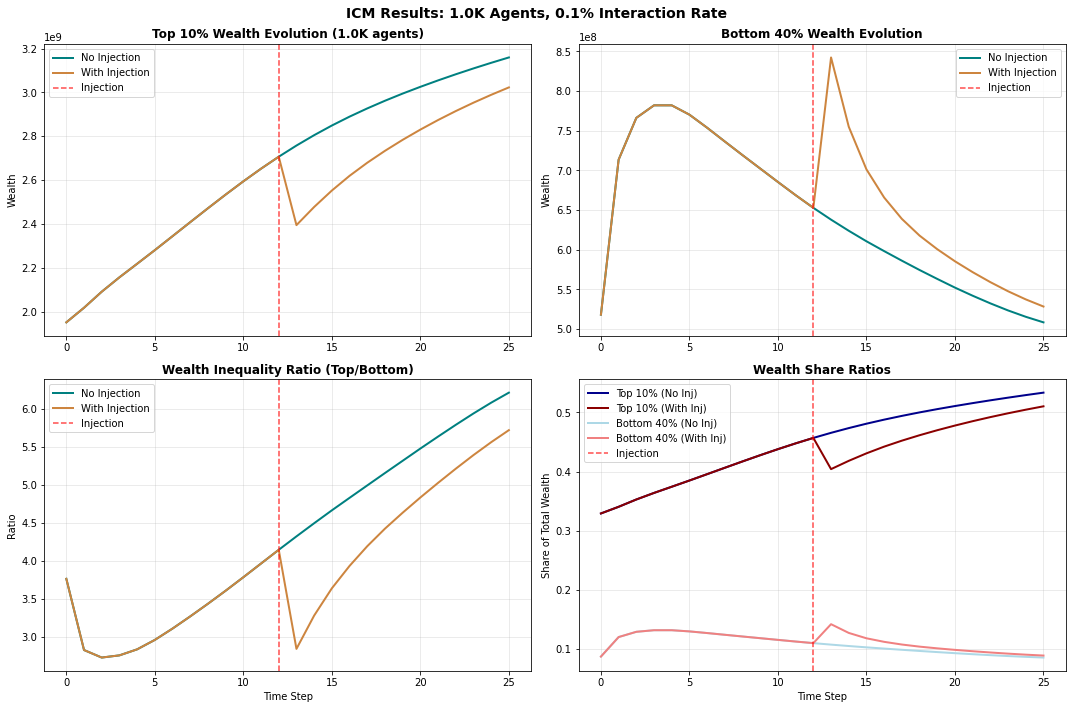

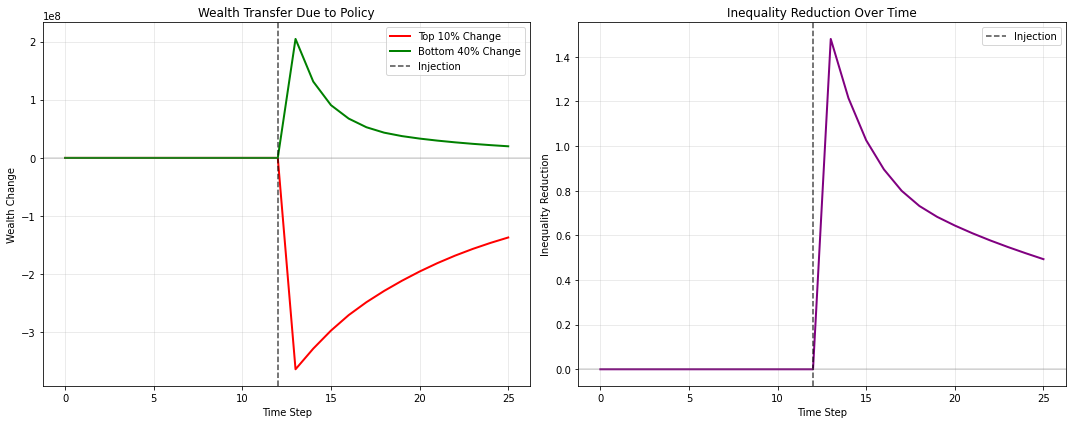

✅ Analysis complete!
🧹 Memory cleaned up


In [27]:
print("📈 Creating optimized visualization...")

# Create streamlined plots for large dataset
model.plot_wealth_evolution(
    df_no_inj, df_with_inj, 
    injection_step=INJECTION_STEP,
    top_percent=TOP_PERCENT,
    bottom_percent=BOTTOM_PERCENT
)

# Additional insight plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Wealth transfer visualization
steps = df_no_inj['step']
wealth_diff_top = df_with_inj['top_wealth'] - df_no_inj['top_wealth'] 
wealth_diff_bottom = df_with_inj['bottom_wealth'] - df_no_inj['bottom_wealth']

ax1.plot(steps, wealth_diff_top, label='Top 10% Change', color='red', linewidth=2)
ax1.plot(steps, wealth_diff_bottom, label='Bottom 40% Change', color='green', linewidth=2)
ax1.axvline(INJECTION_STEP, color='black', linestyle='--', alpha=0.7, label='Injection')
ax1.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax1.set_title('Wealth Transfer Due to Policy')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Wealth Change')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Convergence analysis
inequality_reduction = df_no_inj['inequality_ratio'] - df_with_inj['inequality_ratio']
ax2.plot(steps, inequality_reduction, color='purple', linewidth=2)
ax2.axvline(INJECTION_STEP, color='black', linestyle='--', alpha=0.7, label='Injection')
ax2.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax2.set_title('Inequality Reduction Over Time')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Inequality Reduction')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Analysis complete!")
cleanup_memory()